In [3]:
# Add project src to path.
import set_path

# Import modules.
import numpy as np
from tqdm import tqdm
import logging
import pandas as pd
import time
import glob

import set_path
import src.utils.ahn_utils as ahn_utils
import src.utils.las_utils as las_utils
import src.utils.log_utils as log_utils
import src.utils.plot_utils as plot_utils
import src.utils.bgt_utils as bgt_utils
import src.analysis.analysis_tools as analysis_tools

log_utils.reset_logger()
log_utils.add_console_logger(level=logging.DEBUG)

logger = logging.getLogger(__name__)

from tramtrack_fuser import TramTrackFuser

In [2]:
# Load data.
tilecode = '2387_9699'

# Labelled LAS file (see Notebook 0).
las_file = '../datasets/Lairessestraat/pointcloud/labelled_' + tilecode + '.laz'
reduced_las_file = '../datasets/Lairessestraat/processed/M2_' + tilecode + '.laz'

# AHN data folder.
ahn_data_folder = '../datasets/Lairessestraat/ahn/'
# File with tram tracks linestrings.
bgt_tram_track_file = '../datasets/Lairessestraat/bgt/bgt_tram_tracks.csv'

# AHNReader for elevation data.
ahn_reader = ahn_utils.NPZReader(ahn_data_folder)

# BGTReader
bgt_tramtrack_reader = bgt_utils.BGTLineReader(bgt_file=bgt_tram_track_file)

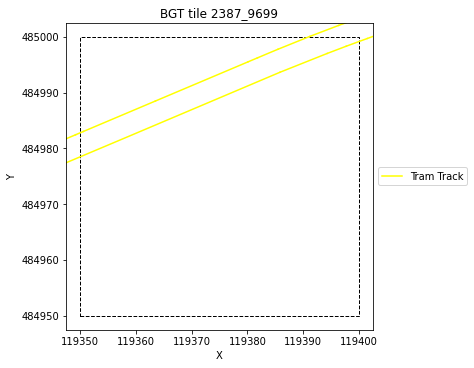

In [3]:
plot_utils.plot_bgt(tilecode, tram_file=bgt_tram_track_file)

In [5]:
# Load pointcloud
pointcloud = las_utils.read_las(las_file)
labels = pointcloud.label
points = np.vstack((pointcloud.x, pointcloud.y, pointcloud.z)).T
pc_colors =  np.vstack((pointcloud.red, pointcloud.blue, pointcloud.green)).T
pc_colors = pc_colors[labels != 0]
points = points[labels != 0]
labels = labels[labels != 0]
mask = labels != 15

In [4]:
# Car fuser using a clustering algorithm and BGT road data.
tramcable_fuser = TramTrackFuser(13, ahn_reader, bgt_reader=bgt_tramtrack_reader)

In [6]:
label_mask = tramcable_fuser.get_label_mask(points, labels, mask, tilecode)

INFO - 2022-04-19 13:12:28,530 - tramtrack_fuser - Tramtrack fuser (label=13


In [12]:
plot_utils.plot_pointcloud_o3d(points, label_mask, exclude_labels=())

#### Batch Folder + Stats

In [48]:
def process_file(in_file, ahn_reader, bgt_tramtrack_reader, folder_path, save_output):
        
    tilecode = las_utils.get_tilecode_from_filename(in_file)
    logger.info(f'Processing file {in_file}.')
    start = time.time()
    
    pointcloud = las_utils.read_las(in_file)
    points = np.vstack((pointcloud.x, pointcloud.y, pointcloud.z)).T
    true_labels = pointcloud.label
    true_labels[(12 < pointcloud.label) & (pointcloud.label < 15)] = 13
    true_labels[pointcloud.label == 12] = 11
    true_labels[pointcloud.label > 14] = 15
    true_mask = true_labels == 11

    pointcloud_labelled = las_utils.read_las(folder_path+'/processed/M2_'+tilecode+'.laz')
    labels_pred = pointcloud_labelled.label
    mask = (labels_pred == 11)

    tramcable_fuser = TramTrackFuser(13, ahn_reader, bgt_reader=bgt_tramtrack_reader)
    label_mask = tramcable_fuser.get_label_mask(points, None, mask, tilecode)
    labels_pred[label_mask] = 13
    labels_pred[(mask & ~label_mask)] = 11

    duration = time.time() - start
    stats, report = analysis_tools.get_cable_stats_m3(labels_pred, true_mask, mask)
    report['time'] = duration
    report['tilecode'] = tilecode

    logger.info('STATISTICS\n' + stats)
    logger.info(f'File processed in {duration:.2f}s.')

    if save_output:
        outpath = folder_path + '/processed/M3_' + tilecode + '.laz'
        las_utils.label_and_save_las(pointcloud, labels_pred, outpath)

    return report

    

In [44]:
def process_folder(folder_path, save_output=False):

    # BGT
    bgt_tram_track_file = folder_path + '/bgt/bgt_tram_tracks.csv'
    bgt_tramtrack_reader = bgt_utils.BGTLineReader(bgt_file=bgt_tram_track_file)

    # AHNReader for elevation data.
    ahn_data_folder = folder_path + '/ahn/'
    ahn_reader = ahn_utils.NPZReader(ahn_data_folder)

    results = []

    for file in glob.iglob(folder_path + '/pointcloud/labelled_*.laz'):
        report = process_file(file, ahn_reader, bgt_tramtrack_reader, folder_path, save_output)
        results.append(report)

    return pd.DataFrame(results)



In [49]:
df = process_folder('../datasets/Lairessestraat', True)

DEBUG - Caching enabled.


INFO - 2022-04-26 13:52:24,945 - 3254148274 - Processing file ../datasets/Lairessestraat/pointcloud/labelled_2394_9702.laz.
INFO - 2022-04-26 13:52:28,611 - tramtrack_fuser - Tramtrack fuser (label=13)
INFO - 2022-04-26 13:52:28,900 - 3254148274 - STATISTICS
Reduced:       8769 -->       1154 points
	Lost:     145 /     779  cable points
	Misclassified:     520 /     779  cable points

INFO - 2022-04-26 13:52:28,901 - 3254148274 - File processed in 3.84s.
INFO - 2022-04-26 13:52:30,593 - 3254148274 - Processing file ../datasets/Lairessestraat/pointcloud/labelled_2388_9700.laz.
INFO - 2022-04-26 13:52:35,956 - tramtrack_fuser - Tramtrack fuser (label=13)
INFO - 2022-04-26 13:52:36,512 - 3254148274 - STATISTICS
Reduced:      21017 -->       3248 points
	Lost:     174 /    3316  cable points
	Misclassified:     106 /    3316  cable points

INFO - 2022-04-26 13:52:36,513 - 3254148274 - File processed in 5.77s.
INFO - 2022-04-26 13:52:38,576 - 3254148274 - Processing file ../datasets/Laires

In [50]:
df

,total_pts,cable_pts,start_pts,end_pts,reduce_per,start_cable_pts,recall_m3,precision_m3,f1_score_m3,time,tilecode
0,4248444,779,8769,1154,0.87,634,1.0,0.549393,0.709172,3.844464,2394_9702
1,5769704,3316,21017,3248,0.85,3142,1.0,0.967365,0.983412,5.773891,2388_9700
2,4853053,932,12624,914,0.93,836,1.0,0.914661,0.955429,4.663352,2389_9700
3,2194654,613,4992,601,0.88,577,1.0,0.960067,0.979626,2.024100,2391_9701
4,2788759,1476,7449,1395,0.81,1383,1.0,0.991398,0.995680,3.614050,2386_9699
5,4379344,4051,23011,4164,0.82,3222,1.0,0.773775,0.872461,4.848273,2387_9699
6,6508713,1482,4253,1611,0.62,1445,1.0,0.896958,0.945681,7.038308,2387_9700


In [47]:
labels = las_utils.read_las('../datasets/Lairessestraat/processed/M1_2386_9699.laz').label

pointcloud = las_utils.read_las('../datasets/Lairessestraat/processed/M3_2386_9699.laz')
points = np.vstack((pointcloud.x, pointcloud.y, pointcloud.z)).T
labels[pointcloud.label==11]=11
labels[pointcloud.label==13]=13

plot_utils.plot_pointcloud_o3d(points, labels)